# **Team: HouseOfDragons**

<font size="4"><b>Team Members:</b><br><font size="4">
<font size="4"><center>Zoltan Kunos<br>
Eyuel Muse<br>
Nikolaos Athanasopoulos<br>
Pol Gareta<br>
Nils Mattiss<br>
</center><font size="4">

# **Predicting fake jobs ads**

In [103]:
!pip install nltk
!pip install imblearn

In [104]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

warnings.filterwarnings("ignore")

In [105]:
#Reading data set
df = pd.read_csv('train.csv')
df_ = pd.read_csv('test.csv')
df.rename(columns={'required_doughnuts_comsumption': 'doughnuts_comsumption'}, inplace=True)

First, let's have a look on missing values.

<AxesSubplot:>

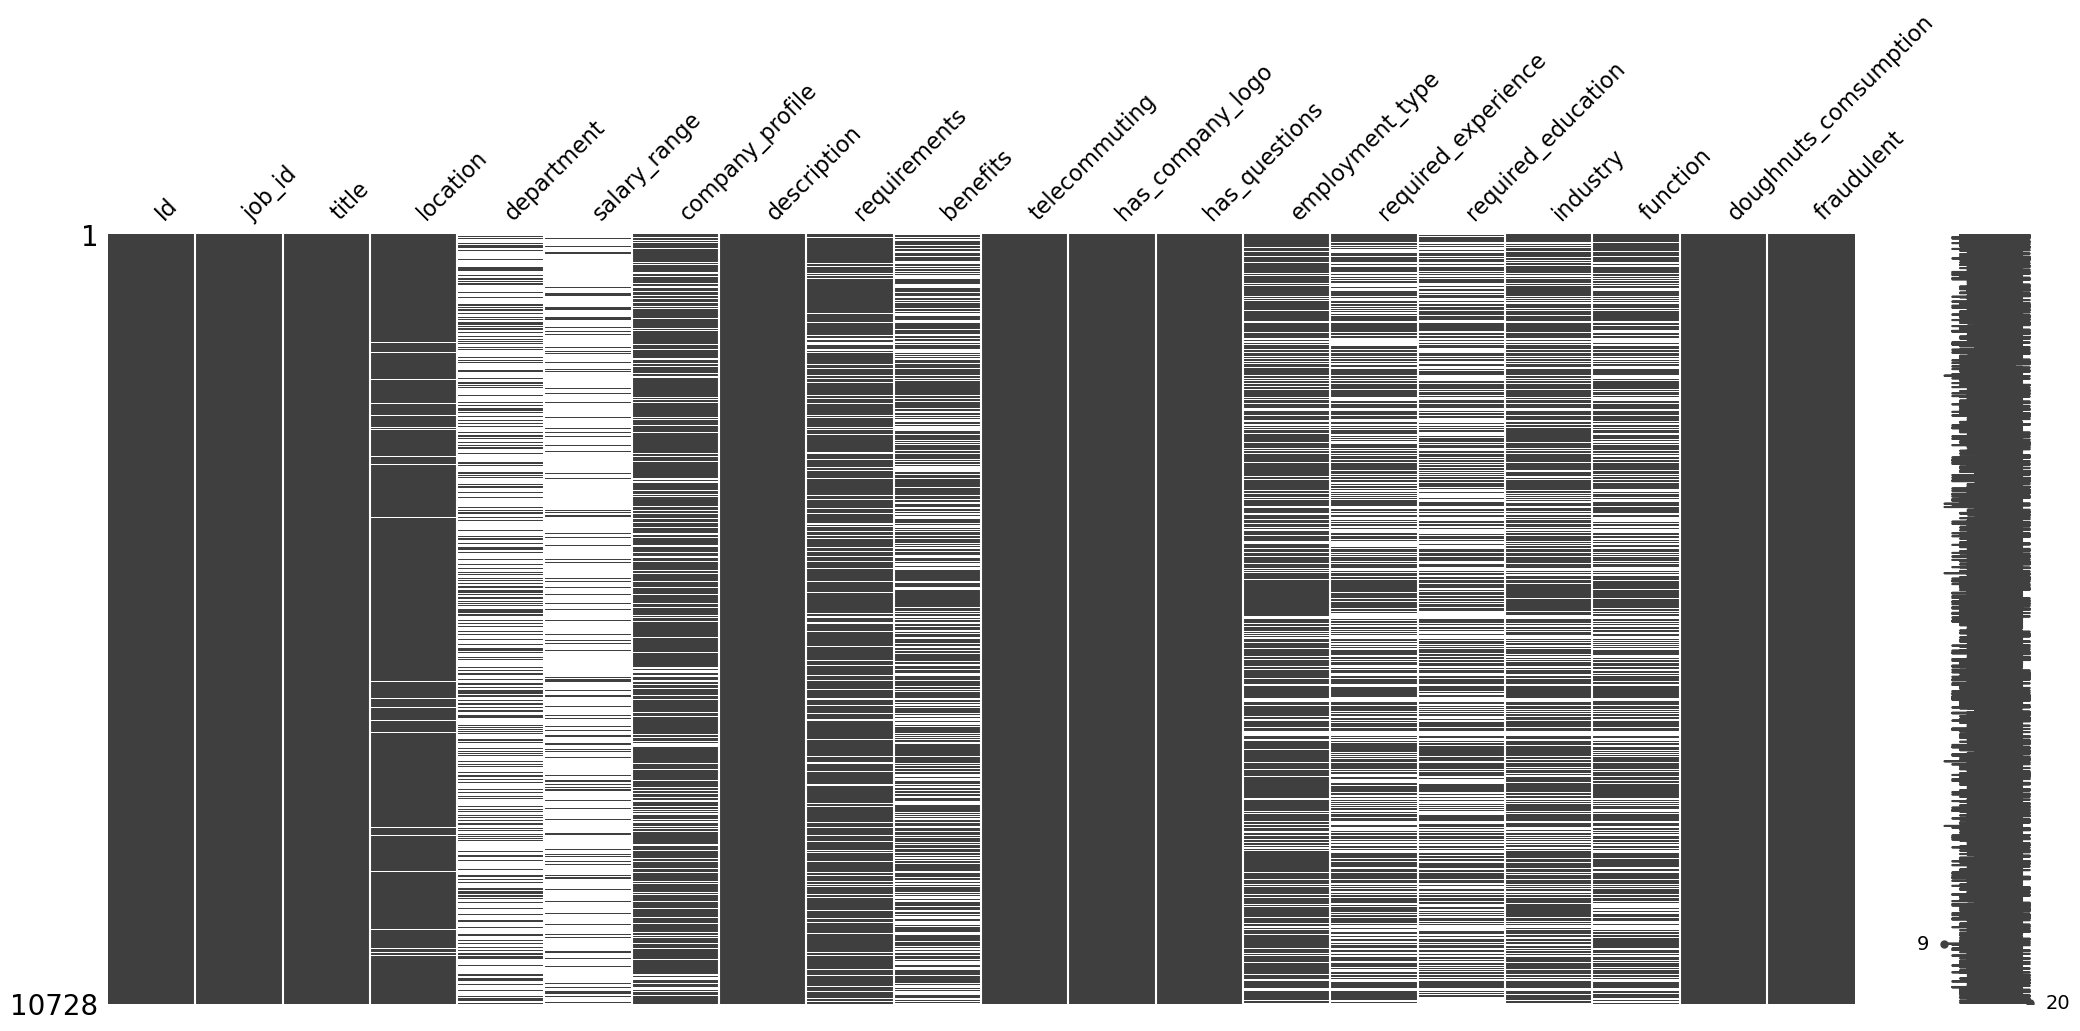

In [106]:
missingno.matrix(df)

In [107]:
def mis_val_percent(df):
    return 100 * df.isnull().sum() / len(df)

In [108]:
mis_val_percent(df)

Id                        0.000000
job_id                    0.000000
title                     0.000000
location                  1.910887
department               65.333706
salary_range             84.069724
company_profile          18.288591
description               0.009321
requirements             15.184564
benefits                 40.715884
telecommuting             0.000000
has_company_logo          0.000000
has_questions             0.000000
employment_type          19.183445
required_experience      39.513423
required_education       45.684191
industry                 27.395600
function                 36.073826
doughnuts_comsumption     0.000000
fraudulent                0.000000
dtype: float64

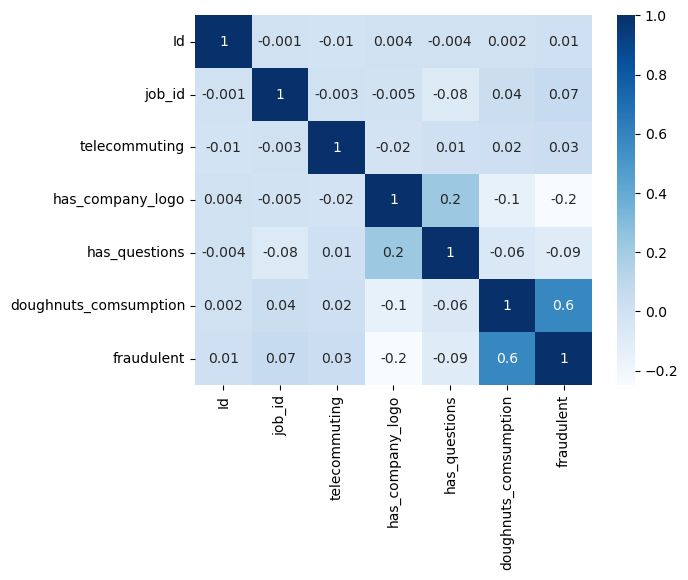

In [109]:
correlations = df.corr()
sns.heatmap(correlations, annot=True,cmap='Blues', fmt='.1g')
plt.show()

There is a high positive correlation with "doughnuts_comsumption", and negative correlation with "has_company_logo" and "has_questions".

Now lets see how many jobs posted are fraud and real. It's a imbalanced dataset, around 95% of the data is not fraudulent.

In [110]:
df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

,fraudulent,title
0,0,10234
1,1,494


In our implementation we replaced the NaN values with the word: 'missing', followed by the name of each column. For example, for the column salary range the NaN values was replaced by the text: 'missingsalaryrange'.

In [111]:
# replaceing missing values
for column in df_.columns:
    df[column] = df[column].fillna(f"missing{column}")
    df_[column] = df_[column].fillna(f"missing{column}")

We also created a new column named "country", which we extracted from the column location.

In [112]:
def split(location):
    l = location.split(",")
    return l[0]

df["country"] = df.location.apply(split)
df_["country"] = df.location.apply(split)

Most fake jobs are posted in the US, followed by the UK.

Text(0.5, 0, 'Countries')

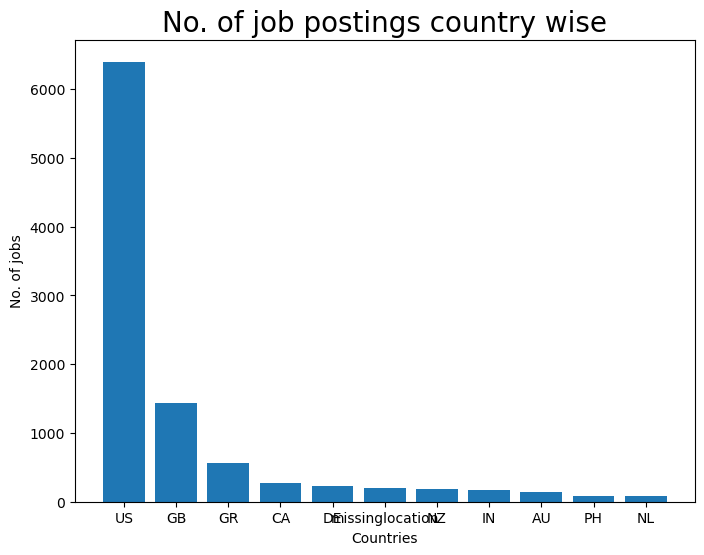

In [113]:
country = dict(df.country.value_counts()[:11])
plt.figure(figsize=(8,6))
plt.title('No. of job postings country wise', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

The content of the column description was replaced with the merged text from the columns that are shown in the following list all together.

In [114]:
# concatinating the text features
text_cols = [
    "title",
    "location",
    "department",
    "salary_range",
    "company_profile",
    "requirements",
    "benefits",
    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
    "country",
]

for column in text_cols:
    df["description"] += " " + df[column]
    df_["description"] += " " + df_[column]

In [115]:
# Downloading data from NLTK
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")
stop_words = list(stopwords.words("english"))
punctuations = string.punctuation

[nltk_data] Downloading package punkt to /home/zozoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zozoka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zozoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zozoka/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **Data cleaning**

Furthermore, we cleaned the content of the column "description" that contains the text for each row combined. To be more specific, we applied the following procedures:
- Remove special characters
- Lower case
- Remove punctuations
- Stopwords Removal (e.g. "a", "the",.. etc)
- Lemmatize Text: we keep only the words in simple format e.g. doing -> do
- Remove url's

In [116]:
df["Content_Parsed_1"] = df["description"].str.replace("\r", " ")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace("\n", " ")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace("    ", " ")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace('"', "")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.lower()
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace("'s", "")

df_["Content_Parsed_1"] = df_["description"].str.replace("\r", " ")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace("\n", " ")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace("    ", " ")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace('"', "")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.lower()
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace("'s", "")

In [117]:
for punct_sign in punctuations:
    df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace(punct_sign, "")
    df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace(punct_sign, "")

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace(regex_stopword, "")
    df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace(regex_stopword, "")

In [118]:
wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    lemmatized_list = []
    text = df.loc[row]["Content_Parsed_1"]
    text_words = text.split(" ")

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list.append(lemmatized_text)

nrows_ = len(df_)
lemmatized_text_list_ = []

for row in range(0, nrows_):
    lemmatized_list = []
    text = df_.loc[row]["Content_Parsed_1"]
    text_words = text.split(" ")

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list_.append(lemmatized_text)

In [119]:
df["Content_Parsed_1"] = lemmatized_text_list
df_["Content_Parsed_1"] = lemmatized_text_list_

In [120]:
df["text_processed"] = df["Content_Parsed_1"].replace("’", "")
df["text_processed"].apply(lambda x: re.sub("(email)|(url)\w+", "", x))
df["text_processed"].apply(lambda x: re.sub("\w*\d\w*", "", x))

df_["text_processed"] = df_["Content_Parsed_1"].replace("’", "")
df_["text_processed"].apply(lambda x: re.sub("(email)|(url)\w+", "", x))
df_["text_processed"].apply(lambda x: re.sub("\w*\d\w*", "", x))

0         several open available   area offer  competi...
1        call center representative   provide  sociall...
2       tpg  search  chief accountant  one   business ...
3        office service associate   base   san jose ca...
4       oracle fusion hcm resourcelocation  north cant...
                              ...                        
7147     uswe take  hassle   find  book  cleaner onlin...
7148      qa engineer    responsible  lead  quality as...
7149     urgently require  day  night trunkers run   a...
7150    experience firmware engineer  require  respons...
7151      fantastic opportunity  someone want  start  ...
Name: text_processed, Length: 7152, dtype: object

Additionaly, we created one more column "text_len", which has numerical values and more specifically contains the length of the text of the desctiption column.

In [121]:
df["text_len"] = df["description"].str.len()
df_["text_len"] = df_["description"].str.len()

Fraudulent postings have shorter descriptions than real postings.

In [122]:
df.groupby('fraudulent')['text_len'].mean()

fraudulent
0    2848.821966
1    2302.823887
Name: text_len, dtype: float64

We used the TfidfVectorizer for the combined text column("description") in order to get numbers from text.

In [123]:
word_vectorizer = TfidfVectorizer(
    encoding="utf-8",
    ngram_range=(1, 2),
    stop_words=None,
    lowercase=False,
    max_df=10,
    min_df=1,
    max_features=8000,
    norm="l2",
    sublinear_tf=True,
)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents="unicode",
    analyzer="char",
    ngram_range=(1, 4),
    dtype=np.float32,
    max_features=8000,
)

In [124]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

## **Features selected**

At the following cell we can see the final features that we used for our model, which are summirised below:
- String Features = "description"
- Categorical Features = "country", "has_company_logo", "has_questions", "telecommuting"
- Numerical Features = "text_len"

In [125]:
str_features = "text_processed"

cat_features = [
    "country",
    "has_company_logo",
    "has_questions",
    "telecommuting"
]

num_features = [  
    #'num',
    #'doughnuts_comsumption',
    "text_len",
    #"job_id",
    #'word_counts',
    #'characters_per_word'
]

In [126]:
text_word = Pipeline(
    [("selector", DataFrameSelector(str_features)), ("vectorizer", word_vectorizer)]
)
text_char = Pipeline(
    [("selector", DataFrameSelector(str_features)), ("vectorizer", char_vectorizer)]
)

text = FeatureUnion([("text_word", text_word), ("text_char", text_char)])

In [127]:
num_feats = Pipeline(
    [
        ("selector", DataFrameSelector(num_features)),
        # ('standard', StandardScaler())
    ]
)

In [128]:
cat_feats = Pipeline(
    [
        ("selector", DataFrameSelector(cat_features)),
        ("encode", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [129]:
feats = FeatureUnion(
    [("text", text), ("num_feats", num_feats), ("cat_feats", cat_feats)]
)

In [130]:
pickle.dump(df, open("data_clean.pkl", "wb"))

In [131]:
y = df["fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
X_ = df_

## **Classifier Selection**

As far as it concerns the classifier selection, we tried a lot of different classifiers, such as:
- LogisticRegression
- XGBoost

But we had the best performance when we used the LinearSVC classifier and therefore this is the classifier that we finally have chosen for our model.

Only for the training we used SMOTE in order to oversample the minority class(ones), by duplicating some examples.

We should also underline the fact that we used the StandardScaler, so that our numerical values would be between 0 and 1.

The aforementioned procedures were implemented using a Pipeline that has the properties that are shown below.

In [132]:
# baseline classifier
clf = LinearSVC()

# Create pipeline 
pipe = imbPipeline(
    [
        ("features", feats),
        ("standard", StandardScaler(with_mean=False)),
        ("selector", SelectFromModel(estimator=LinearSVC())),
        ("SMOTE", SMOTE()),
        ("classifier", clf),
    ]
)

# fitting our model.
pipe.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 FeatureUnion(transformer_list=[('text_word',
                                                                                 Pipeline(steps=[('selector',
                                                                                                  DataFrameSelector(attribute_names='text_processed')),
                                                                                                 ('vectorizer',
                                                                                                  TfidfVectorizer(lowercase=False,
                                                                                                                  max_df=10,
                                                                                                                  max_features=8000,
                                                                                                                  ngram_range=(1,
                                                                                                                               2),
                                                                                                                  sublinear_tf=True))])),
                                                                                ('text_char',
                                                                                 Pipeline(steps=[('selector',
                                                                                                  Da...
                                                                  DataFrameSelector(attribute_names=['text_len']))])),
                                                ('cat_feats',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['country',
                                                                                                     'has_company_logo',
                                                                                                     'has_questions',
                                                                                                     'telecommuting'])),
                                                                 ('encode',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('standard', StandardScaler(with_mean=False)),
                ('selector', SelectFromModel(estimator=LinearSVC())),
                ('SMOTE', SMOTE()), ('classifier', LinearSVC())])

In [24]:
pickle.dump(pipe, open("model.pkl", "wb"))

In [134]:
predicted_LinearSVC = pipe.predict(X_test)
np.sum(predicted_LinearSVC)

88

## **Model Accuracy**

In [135]:
# Model Accuracy
print("LinearSVC Accuracy:", accuracy_score(y_test, predicted_LinearSVC))
print("LinearSVC Recall:", recall_score(y_test, predicted_LinearSVC))
print(roc_auc_score(y_test, predicted_LinearSVC))
print(classification_report(y_test, predicted_LinearSVC))
print(f"confusion_matrix:\n {confusion_matrix(y_test, predicted_LinearSVC)}")

LinearSVC Accuracy: 0.9846225535880708
LinearSVC Recall: 0.7835051546391752
0.8888243196329111
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2049
           1       0.86      0.78      0.82        97

    accuracy                           0.98      2146
   macro avg       0.93      0.89      0.91      2146
weighted avg       0.98      0.98      0.98      2146

confusion_matrix:
 [[2037   12]
 [  21   76]]


We observe that our results are rather good. To be more specific, the precision, recall and the f1-score for the majority class (zeros) are almost perfect(very close to 1.0). Regarding the minority class(ones), we got the following metrics:
- precision_macro_avg: 0.93
- recall_macro_avg: 0.89
- f1-score_macro_avg: 0.91

FN+FP = 33

<br>In the following section we present the confusion matrix.

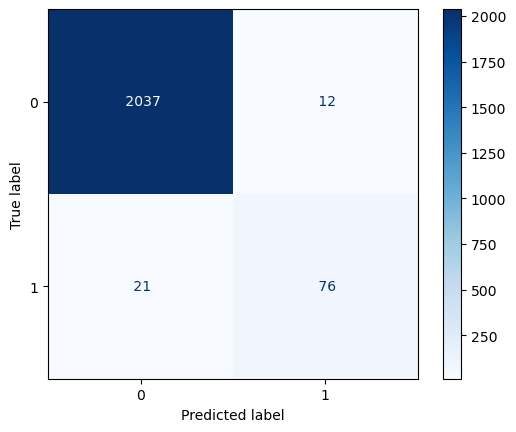

In [138]:
plot_confusion_matrix(pipe, X_test, y_test, cmap="Blues", values_format=" ")

## **Hyperparameter tuning**

In [136]:
parameters = {
    #'classifier__class_weight' : ['none', 'balanced', '{0:1, 1:10}'],
    #'classifier__penalty' : ['l1','l2'],
    #'classifier__C'       : np.logspace(-4,4,9),
    #'classifier__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    "classifier__C": np.logspace(-4, 4, 9),
    "classifier__tol": [10, 1, 0.1, 0.01],
}

In [ ]:
clf_GS = GridSearchCV(pipe, parameters, cv=4, n_jobs=4, verbose=1)
clf_GS.fit(X_train, y_train)

In [32]:
print("Tuned Hyperparameters :", clf_GS.best_params_)
print("Accuracy :", clf_GS.best_score_)

Tuned Hyperparameters : {'classifier__C': 0.0001, 'classifier__tol': 1}
Accuracy : 0.9839198322069448


In [137]:
clf_tuned = LinearSVC(C=0.0001, tol=1)

# Create pipeline 
pipe_tuned = imbPipeline(
    [
        ("features", feats),
        ("standard", StandardScaler(with_mean=False)),
        ("selector", SelectFromModel(estimator=LinearSVC())),
        ("SMOTE", SMOTE()),
        ("classifier", clf_tuned),
    ]
)

# fitting our model.
pipe_tuned.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 FeatureUnion(transformer_list=[('text_word',
                                                                                 Pipeline(steps=[('selector',
                                                                                                  DataFrameSelector(attribute_names='text_processed')),
                                                                                                 ('vectorizer',
                                                                                                  TfidfVectorizer(lowercase=False,
                                                                                                                  max_df=10,
                                                                                                                  max_features=8000,
                                                                                                                  ngram_range=(1,
                                                                                                                               2),
                                                                                                                  sublinear_tf=True))])),
                                                                                ('text_char',
                                                                                 Pipeline(steps=[('selector',
                                                                                                  Da...
                                                ('cat_feats',
                                                 Pipeline(steps=[('selector',
                                                                  DataFrameSelector(attribute_names=['country',
                                                                                                     'has_company_logo',
                                                                                                     'has_questions',
                                                                                                     'telecommuting'])),
                                                                 ('encode',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('standard', StandardScaler(with_mean=False)),
                ('selector', SelectFromModel(estimator=LinearSVC())),
                ('SMOTE', SMOTE()),
                ('classifier', LinearSVC(C=0.0001, tol=1))])

In [ ]:
pickle.dump(pipe, open("model_tuned.pkl", "wb"))

In [139]:
predicted_LinearSVC = pipe_tuned.predict(X_test)
np.sum(predicted_LinearSVC)

89

In [ ]:
predicted_LinearSVC_X_ = pipe_tuned.predict(X_)
np.sum(predicted_LinearSVC_X_)

In [45]:
file = pd.DataFrame(predicted_LinearSVC_X_)
file.index.name = "Id"
file.to_csv("pred_LinearSVC.csv", index=True, header=["Category"])

In [140]:
# Model Accuracy
print("LinearSVC Accuracy:", accuracy_score(y_test, predicted_LinearSVC))
print("LinearSVC Recall:", recall_score(y_test, predicted_LinearSVC))
print(roc_auc_score(y_test, predicted_LinearSVC))
print(classification_report(y_test, predicted_LinearSVC))
print(f"confusion_matrix:\n {confusion_matrix(y_test, predicted_LinearSVC)}")

LinearSVC Accuracy: 0.9860205032618826
LinearSVC Recall: 0.8041237113402062
0.8993776194573163
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2049
           1       0.88      0.80      0.84        97

    accuracy                           0.99      2146
   macro avg       0.93      0.90      0.92      2146
weighted avg       0.99      0.99      0.99      2146

confusion_matrix:
 [[2038   11]
 [  19   78]]


We can see an improvement in the metrics of the minority class(ones 88 vs 89), when we use the LinearSVC classifier with the following hyperparameters: {'classifier__C': 0.0001, 'classifier__tol': 1}. 

FN+FP = 30 (improvement of 3)

<br>Sadly we did not have any free upload slot on Kaggle, so our best Kaggle score was made by the baseline model. But we expect that our tuned model would have a better score.

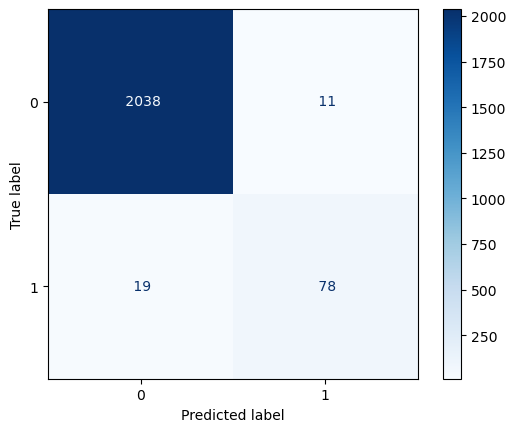

In [141]:
plot_confusion_matrix(pipe_tuned, X_test, y_test, cmap="Blues", values_format=" ")